## EARIN Lab - Exercise 5
## N-layer perceptron for Iris Classification
## Krzysztof Piotrowski, Mieszko Niewiarowski

In [51]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt

## Data import

In [52]:
df = pd.read_csv("Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


## Data preprocessing

The first step is to check which columns are important and which not. The 'Id' column does not have effect on the training procedure, therefore it can be removed.

In [53]:
df = df.drop(["Id"], axis=1)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Then, we check whether dataframe contains null values or not. In this case all values are provided and it does not require any additional actions related to filling the data. It is important to note that 'Species' column is a categorical column.

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


The next step is to transform categorical column into numerical values in order to train the model. 'Species' column consists of 3 values ('Iris-setosa', 'Iris-versicolor' and 'Iris-virginica'). We transformed those values into numbers: 0, 1, 2.

In [55]:
categories = df['Species'].unique()
print(categories)

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [56]:
df['Species'] = df['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


After that, we split datasest into the train (80% of original dataset) and the test (20% of original dataset) datasets. Then we transformed them into inputs and targets for loss functions.

In [57]:
X = df.drop('Species', axis=1).values
y = df['Species'].values

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Below we can preview dataset that we are working on. Each of the Iris species is seprated visibly from other species. Thanks to that it will ease up the process of classification.

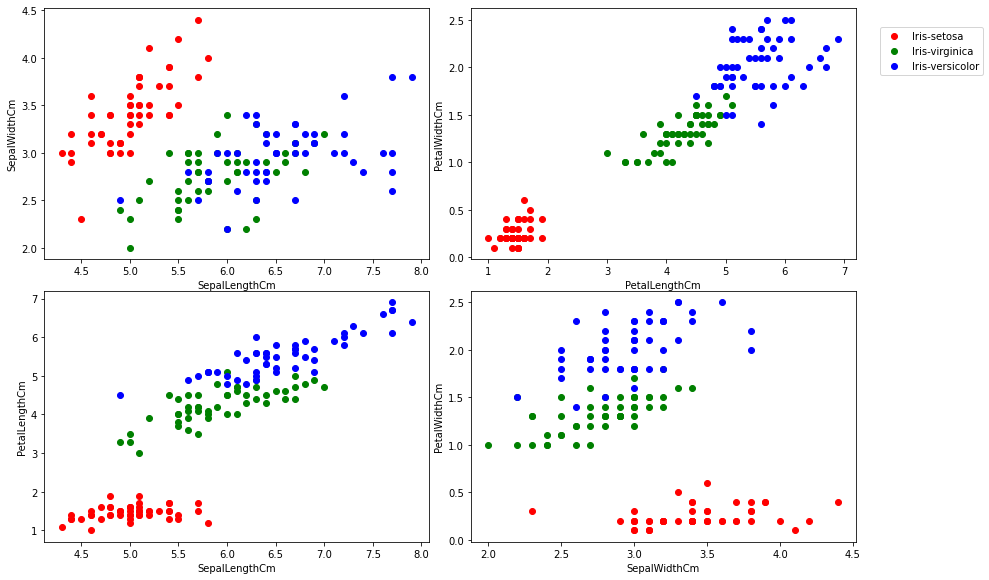

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ["r", "g", "b"]
labels = ["Iris-setosa","Iris-virginica","Iris-versicolor"]

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df["Species"]==j][x], df[df["Species"]==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

In [60]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

## Creating Models
Now, we can define 2 models to investigate the influence of number of the layers on the metrics of the model such as: accuracy, precision, recall. The first model consists of 3 layers in total and the second consists of 5 layers. Additionally, we check the impact of neuron numbers in each layer. We noticed that it does not change too much for small numbers but for higher it may cause some significant anomalies. For the neural network model we decided to take rectified linear units as an activation function.

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class PerceptronLayer3(nn.Module):
    def __init__(self, input_features=4, hidden_layer1=500, hidden_layer2=300, output_features=3):
        super().__init__()
        self.fc1 = nn.Linear(input_features, hidden_layer1)                  
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)                  
        self.out = nn.Linear(hidden_layer2, output_features)
        self.dropout = nn.Dropout(0.1)    
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [62]:
class PerceptronLayer5(nn.Module):
    def __init__(self, input_features=4, hidden_layer1=600, hidden_layer2=300, hidden_layer3=150, hidden_layer4=75, output_features=3):
        super().__init__()
        self.fc1 = nn.Linear(input_features, hidden_layer1)                  
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.fc3 = nn.Linear(hidden_layer2, hidden_layer3)
        self.fc4 = nn.Linear(hidden_layer3, hidden_layer4)                  
        self.out = nn.Linear(hidden_layer4, output_features)      
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.out(x)
        return x

## Training Function
Subsequently, we defined the method for the training procedure. It is possible to choose the previously defined classes, epochs, datasets, cost functions and optimizer options.

In [63]:
def train(model, epochs, X_train, y_train, cost_funtion, optimizer):
    losses = []
    accuracy = []
    for _ in range(epochs):
        optimizer.zero_grad()
        
        y_pred = model.forward(X_train)
        
        loss = cost_funtion(y_pred, y_train)
        losses.append(loss.item())
        loss.backward()
        
        optimizer.step()
        accuracy.append(accuracy_score(y_pred.argmax(1), y_train))
    
    return losses, accuracy

## Learning procedure
Then, we trained our data and we investigated metrics obtained using standard sklearn methods. We checked our results for 2 previously defined models and 2 different cost functions(Cross Entropy Loss and Multi margin loss).

### 3 Layer perceptron - Cross entropy loss

In [64]:
model_3_layers = PerceptronLayer3(X_train.shape[1])
cost_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3_layers.parameters(), lr=0.01, momentum=0.9)
epochs = 200

(losses, accuracy) = train(model_3_layers, epochs, X_train, y_train, cost_function, optimizer)

preds = []
with torch.no_grad():
    for val in X_test:
        y_test_prediction = model_3_layers.forward(val)
        preds.append(y_test_prediction.argmax().item())

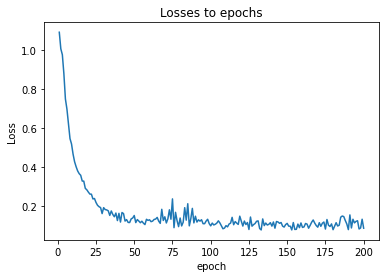

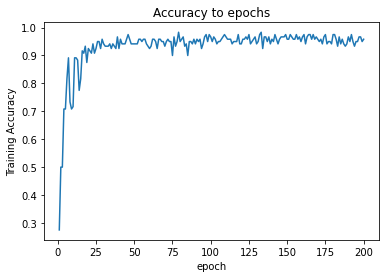

In [65]:
x_axis = np.arange(1, epochs+1)
fig1, ax1= plt.subplots()
ax1.plot(x_axis, losses)
ax1.set_title("Losses to epochs")
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch');

fig2, ax2 = plt.subplots()
ax2.plot(x_axis, accuracy)
ax2.set_title("Accuracy to epochs")
ax2.set_ylabel('Training Accuracy')
ax2.set_xlabel('epoch');

In [66]:
acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds, average="macro")
recall = recall_score(y_test, preds, average="macro")
print("Accuracy: " + str(acc))
print("Precision: " + str(prec))
print("Recall: " + str(recall))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


### 3 Layer perceptron -  Multi Margin Loss

In [67]:
model_3_layers = PerceptronLayer3(X_train.shape[1])
cost_function = nn.MultiMarginLoss()
optimizer = torch.optim.SGD(model_3_layers.parameters(), lr=0.01, momentum=0.9)
epochs = 200

(losses, accuracy) = train(model_3_layers, epochs, X_train, y_train, cost_function, optimizer)

preds = []
with torch.no_grad():
    for val in X_test:
        y_test_prediction = model_3_layers.forward(val)
        preds.append(y_test_prediction.argmax().item())

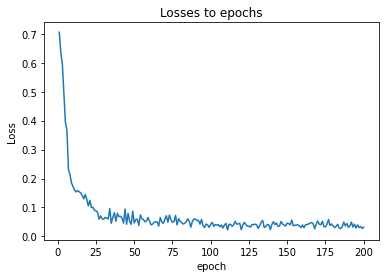

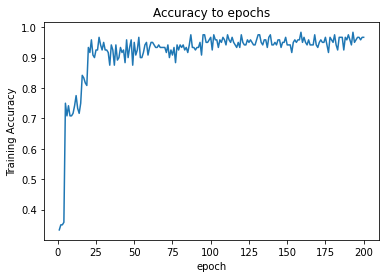

In [68]:
x_axis = np.arange(1, epochs+1)
fig1, ax1= plt.subplots()
ax1.plot(x_axis, losses)
ax1.set_title("Losses to epochs")
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch');

fig2, ax2 = plt.subplots()
ax2.plot(x_axis, accuracy)
ax2.set_title("Accuracy to epochs")
ax2.set_ylabel('Training Accuracy')
ax2.set_xlabel('epoch');

In [69]:
acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds, average="macro")
recall = recall_score(y_test, preds, average="macro")
print("Accuracy: " + str(acc))
print("Precision: " + str(prec))
print("Recall: " + str(recall))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


### 5 layer perceptron - Cross entropy loss

In [70]:
model_5_layers = PerceptronLayer5(X_train.shape[1])
cost_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_5_layers.parameters(), lr=0.01, momentum=0.9)
epochs = 200

(losses, accuracy) = train(model_5_layers, epochs, X_train, y_train, cost_function, optimizer)

preds = []
with torch.no_grad():
    for val in X_test:
        y_test_prediction = model_5_layers.forward(val)
        preds.append(y_test_prediction.argmax().item())

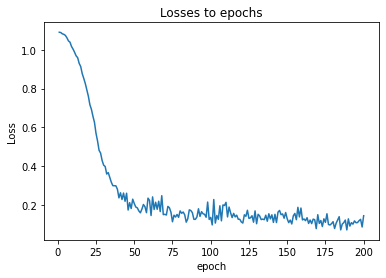

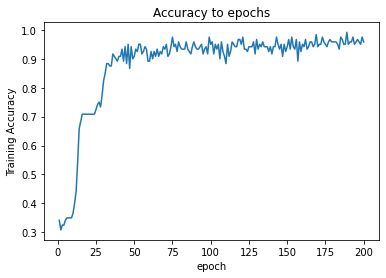

In [71]:
x_axis = np.arange(1, epochs+1)
fig1, ax1= plt.subplots()
ax1.plot(x_axis, losses)
ax1.set_title("Losses to epochs")
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch');

fig2, ax2 = plt.subplots()
ax2.plot(x_axis, accuracy)
ax2.set_title("Accuracy to epochs")
ax2.set_ylabel('Training Accuracy')
ax2.set_xlabel('epoch');

In [72]:
acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds, average="macro")
recall = recall_score(y_test, preds, average="macro")
print("Accuracy: " + str(acc))
print("Precision: " + str(prec))
print("Recall: " + str(recall))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


### 5 layer perceptron - Multi Margin Loss

In [73]:
model_5_layers = PerceptronLayer5(X_train.shape[1])
cost_function = nn.MultiMarginLoss()
optimizer = torch.optim.SGD(model_5_layers.parameters(), lr=0.01, momentum=0.9)
epochs = 200

(losses, accuracy) = train(model_5_layers, epochs, X_train, y_train, cost_function, optimizer)

preds = []
with torch.no_grad():
    for val in X_test:
        y_test_prediction = model_5_layers.forward(val)
        preds.append(y_test_prediction.argmax().item())

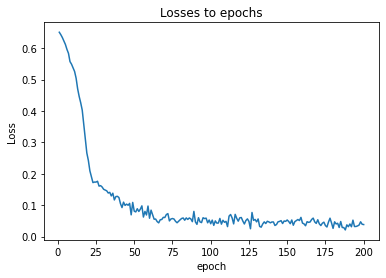

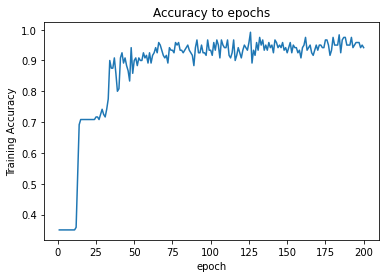

In [74]:
x_axis = np.arange(1, epochs+1)
fig1, ax1= plt.subplots()
ax1.plot(x_axis, losses)
ax1.set_title("Losses to epochs")
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch');

fig2, ax2 = plt.subplots()
ax2.plot(x_axis, accuracy)
ax2.set_title("Accuracy to epochs")
ax2.set_ylabel('Training Accuracy')
ax2.set_xlabel('epoch');

In [75]:
acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds, average="macro")
recall = recall_score(y_test, preds, average="macro")
print("Accuracy: " + str(acc))
print("Precision: " + str(prec))
print("Recall: " + str(recall))

Accuracy: 0.9666666666666667
Precision: 0.9791666666666666
Recall: 0.9583333333333334


# Summary

Our results oscilated in the range between 93% up to 100% for each metric (accuracy, precision and recall). The main reason why we obtain different results is the way the set is splitted into training and testing set. We came to conclusion that the number of layers did not affect results of our research. It is corelated with number of iris classification. Without the use of dropout, number of neurons did not affect our model training however, according to accuracy plot, it was overfitting couple times. After we applied the dropout, it prevented co-adaptation of neurons thus, the drops on accuracy plot were reduced. 